Sample data:
                                               Title            Company  \
0                                       Data Analyst             Stripe   
1                            Analyst, Data Analytics  Bath & Body Works   
2  Data Analyst, Production Finance Operations & ...            Netflix   
3                                       Data Analyst            FanDuel   
4                              Business Data Analyst               Meta   

              City                                               Link  \
0    United States  https://www.linkedin.com/jobs/view/data-analys...   
1     Columbus, OH  https://www.linkedin.com/jobs/view/analyst-dat...   
2  Los Angeles, CA  https://www.linkedin.com/jobs/view/data-analys...   
3     New York, NY  https://www.linkedin.com/jobs/view/data-analys...   
4       Austin, TX  https://www.linkedin.com/jobs/view/business-da...   

                                         Description  \
0  About StripeStripe is a financial infr

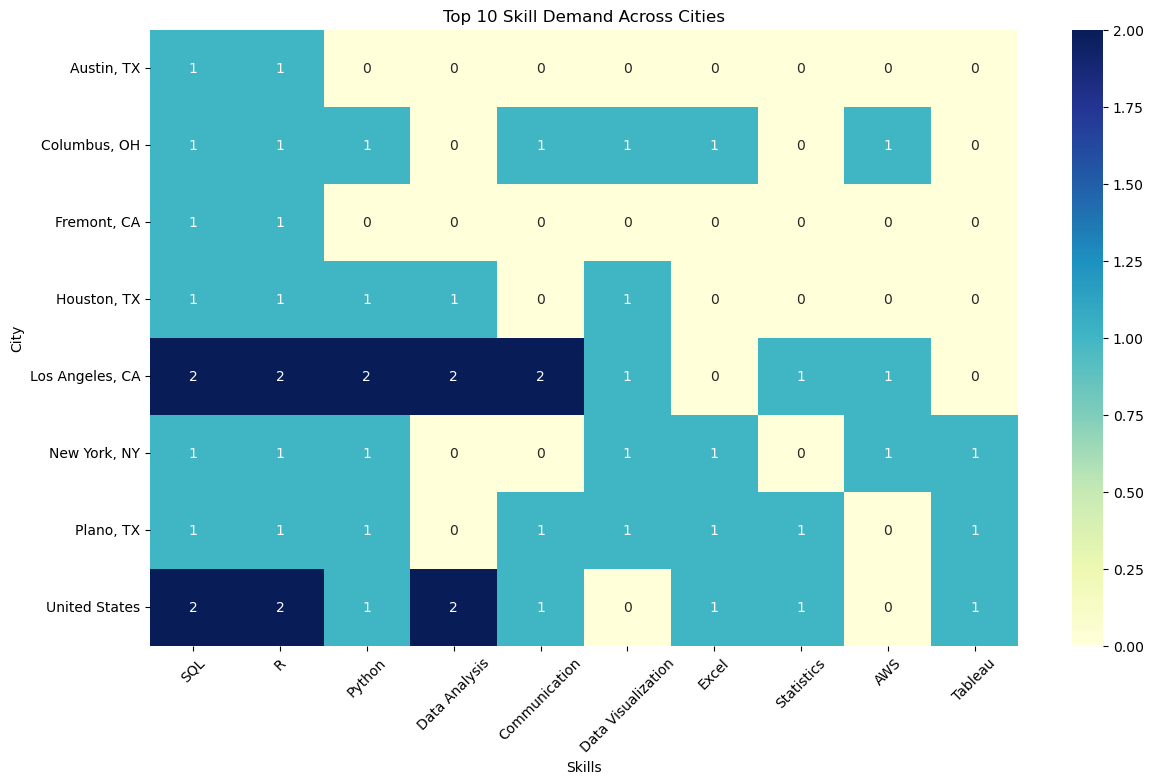

Files saved: 'linkedin_job_data.csv', 'skill_vs_city_matrix.csv'


In [1]:
# Step 1: Import Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Step 2: Define Target URL
keywords = "Data Analyst"
location = ""

# Encode keywords and location
keywords = keywords.replace(' ', '%20')
location = location.replace(' ', '%20')

base_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={keywords}&location={location}"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

# Step 3: Scrape Job Listings
response = requests.get(base_url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

jobs = []

# Define skill keywords (you can expand this)
skill_keywords = [
    'Python', 'SQL', 'Excel', 'Power BI', 'Tableau', 'R', 'Machine Learning',
    'Data Analysis', 'Statistics', 'AWS', 'Azure', 'Communication', 'Leadership',
    'Data Visualization', 'ETL', 'Business Intelligence', 'Big Data'
]

for job_card in soup.find_all('li'):
    try:
        title = job_card.find('h3', class_='base-search-card__title').text.strip()
    except:
        title = None

    try:
        company = job_card.find('h4', class_='base-search-card__subtitle').text.strip()
    except:
        company = None

    try:
        city = job_card.find('span', class_='job-search-card__location').text.strip()
    except:
        city = None

    try:
        link = job_card.find('a', class_='base-card__full-link')['href']
    except:
        link = None

    description = None
    matched_skills = []

    # Scrape each job detail page
    if link:
        try:
            job_response = requests.get(link, headers=headers)
            job_soup = BeautifulSoup(job_response.text, 'html.parser')

            desc_tag = job_soup.find('div', class_='show-more-less-html__markup')
            if desc_tag:
                description = desc_tag.text.strip()

                # Match skills
                for skill in skill_keywords:
                    if skill.lower() in description.lower():
                        matched_skills.append(skill)

            time.sleep(1)  # Respectful scraping

        except Exception as e:
            print(f"Error fetching job detail: {e}")
            description = None

    jobs.append({
        'Title': title,
        'Company': company,
        'City': city,
        'Link': link,
        'Description': description,
        'Skills': matched_skills
    })

# Step 4: Create DataFrame
df = pd.DataFrame(jobs)

print("Sample data:")
print(df.head())

# Step 5: Explode Skills List
df_exploded = df.explode('Skills').dropna(subset=['Skills'])

# Step 6: Group by City and Skill
pivot_table = df_exploded.pivot_table(index='City', columns='Skills', aggfunc='size', fill_value=0)

# Step 7: Select Top 10 Skills Overall
top_skills = df_exploded['Skills'].value_counts().head(10).index
pivot_table_top = pivot_table[top_skills]

# Step 8: Plot Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table_top, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Top 10 Skill Demand Across Cities')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Step 9: Save Data
df.to_csv('linkedin_job_data.csv', index=False)
pivot_table_top.to_csv('skill_vs_city_matrix.csv')

print("Files saved: 'linkedin_job_data.csv', 'skill_vs_city_matrix.csv'")
